# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


## TD7 : Mélanges de lois


Ce TD est composé de trois exercices. Le premier concerne l'utilisation du mélange de lois normales pour effectuer une classification. Le deuxième exercice concerne la génération d'un échantillon aléatoire d'un mélange de deux lois exponentielles et l'estimation de ses paramètres avec l'échantillonnage de Gibbs. L'estimation des paramètres avec l'algorithme EM constitue l'objet du troisième exercice.

In [1]:
using CSV, DataFrames, Statistics, Distributions, Gadfly
include("functions.jl");

┌ Info: Recompiling stale cache file /Users/jalbert/.julia/compiled/v1.2/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jalbert/.julia/compiled/v1.2/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1240
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


## Exercice 1 - Salaires des diplômés en fonction du type d'université

Dans cet exercice, nous étudierons le salaire médian des diplomés au États-Unis en fonction du type d'université :

- Engineering
- Ivy League 
- Liberal Arts
- Party    
- State

Les données proviennent de *PayScale Inc.* et ont été récupérées sur le site web du *Wall Street Journal* :
http://online.wsj.com/public/resources/documents/info-Salaries_for_Colleges_by_Type-sort.html.

In [2]:
# Chargement des données

data = CSV.read("salaries.csv")
first(data,5)

,School Name,School Type,Starting Median Salary
,String,String,Int64
1,Massachusetts Institute of Technology (MIT),Engineering,72200
2,California Institute of Technology (CIT),Engineering,75500
3,Harvey Mudd College,Engineering,71800
4,Polytechnic University of New York Brooklyn,Engineering,62400
5,Cooper Union,Engineering,62200


In [3]:
# Affichage du nom des colonnes du DataFrame
names(data)

8-element Array{Symbol,1}:
 Symbol("School Name")                      
 Symbol("School Type")                      
 Symbol("Starting Median Salary")           
 Symbol("Mid-Career Median Salary")         
 Symbol("Mid-Career 10th Percentile Salary")
 Symbol("Mid-Career 25th Percentile Salary")
 Symbol("Mid-Career 75th Percentile Salary")
 Symbol("Mid-Career 90th Percentile Salary")

In [4]:
# Transformation des salaires en milliers de dollars pour un affichage plus élégant
for i=3:8
    data[!,i] = data[:,i]/1000
end

### (a) Illustrez l'histogramme des salaires médians des diplomés en début de carrière

Pour que votre graphique soit plus élégant, vous pouvez afficher le salaire médian en milliers de dollars (k$). Le nombre de classe de l'histogramme devrait être environ la racine carré du nombre d'observations.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


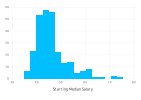

In [5]:
n = size(data,1)
nbin = Int64(floor(sqrt(n)))

plot(data, x=Symbol("Starting Median Salary"), Geom.histogram(bincount=nbin))

### (b) Illustrez les diagrammes en boîtes salaires médians des diplomés en début de carrière en fonction des types d'école

Avec la librairie Gadfly, utilisez la géométrie Geom.boxplot pour illustrer des diagrammes en boîte.

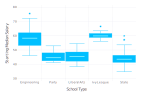

In [6]:
plot(data,x=Symbol("School Type"), y=Symbol("Starting Median Salary"), Geom.boxplot)

### (c) Estimez les paramètres d'un mélange de deux lois normales avec l'algorithme EM

L'algorithme EM pour un mélange de deux lois normales est fourni dans le fichier *functions.jl*. Il s'agit de la fonction `GMMemfit(y::Vector{<:Real})`. La sortie de cette fonction donne un objet de type *MixtureModel* qui s'utilise avec les méthodes standards (`pdf`, `logpdf`, etc.) de la librairie *Distributions*. Les méthodes suivantes sont particulières au type *MixtureModel*:
- `probs(fd::MixtureModel)` : retourne le vecteur des poids de chacune des composantes ;
- `component(fd::MixtureModel, k)` : retourne un objet de type *Distribution* correspondant à la composante k.

In [7]:
y = data[:,Symbol("Starting Median Salary")]  

fd = GMMemfit(y)

Convergence reached in 173 iterations


MixtureModel{Normal}(K = 2)
components[1] (prior = 0.2480): Normal{Float64}(μ=53.31222338418573, σ=7.775649958354746)
components[2] (prior = 0.7520): Normal{Float64}(μ=43.67917918376337, σ=3.394743499106038)


In [8]:
if mean(component(fd, 2)) < mean(component(fd, 1))
    f₀ = component(fd, 2)
    f₁ = component(fd, 1)
    ω = probs(fd)[1]
    
    fd = GMM(ω, mean(f₀), std(f₀), mean(f₁), std(f₁))
end

MixtureModel{Normal}(K = 2)
components[1] (prior = 0.7520): Normal{Float64}(μ=43.67917918376337, σ=3.394743499106038)
components[2] (prior = 0.2480): Normal{Float64}(μ=53.31222338418573, σ=7.775649958354746)


### (d) Tracez les densités des deux composantes obtenues ainsi que la densité du mélange

Tracez ces densités pour les salaires médians de 30 à 50 k$. 

Pour un affichage simplifié, vous pouvez créer un DataFrame avec une colonne pour $x$, une colonne pour le première composante f₀, une colonne pour la deuxième composante f₁ et une colonne pour le mélange f. Ensuite, vous pouvez utiliser la fonction `melt(df, :x)` pour transformer les colonnes de votre DataFrame en variables utiles pour l'affichage.

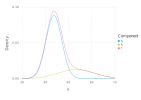

In [9]:
x = 30:.1:70

df = DataFrame(x=x, f₀ = probs(fd)[1]*pdf.(component(fd, 1),x), f₁ = probs(fd)[2]*pdf.(component(fd, 2),x), f=pdf.(fd,x) )

df = melt(df, :x)
rename!(df, :variable => :Component, :value => :Density)

plot(df, x=:x, y=:Density, color=:Component, Geom.line)


### (e) Estimez pour chacun des salaires médians la probabilité qu'il provienne de la composante de plus grande moyenne

In [10]:
log_p = log(probs(fd)[2]) .+ logpdf.(component(fd, 2),y) - logpdf.(fd,y)

p = exp.(log_p) ; 

### (f) Combien d'universités de chaque type se retrouve dans la catégorie correspondante à la composante ayant  la moyenne la plus élevée pour les salaires médians.

Supposez que les observations pour lesquelles p>1/2 proviennent de la composante avec la plus grande moyenne.

[**Optionel**]Pour dénombrer par type, vous pouvez utilisez la fonction *by()* de la librairie *DataFrame*.

In [11]:
groupe1 = p .> .5

by(data[groupe1,:], Symbol("School Type"), Symbol("School Type") => length)

,School Type,School Type_length
,String,Int64
1,Engineering,17
2,Party,3
3,LiberalArts,7
4,IvyLeague,8
5,State,14


### (g) Combien d'universités de chaque type se retrouve dans la catégorie correspondante à la composante ayant  la moyenne la plus basse pour les salaires médians.

In [12]:
groupe0 = p .< .5

by(data[groupe0,:], Symbol("School Type"), Symbol("School Type") => length)

,School Type,School Type_length
,String,Int64
1,Engineering,2
2,Party,17
3,LiberalArts,40
4,State,161


### (h) Quelles sont les universités d'état qui se comparent aux grandes universités ?

In [13]:
df = data[groupe1,:]
ind = df[:, Symbol("School Type")] .=="State"
df[ind,:]

,School Name,School Type,Starting Median Salary
,String,String,Float64
1,University of California Berkeley,State,59.9
2,University of Virginia (UVA),State,52.7
3,Cal Poly San Luis Obispo,State,57.2
4,University of California at Los Angeles (UCLA),State,52.6
5,University of California San Diego (UCSD),State,51.1
6,University of California Davis,State,52.3
7,University of Illinois at Urbana-Champaign (UIUC),State,52.9
8,Binghamton University,State,53.6
9,University of Missouri - Rolla (UMR),State,57.1


### (i) Quelles sont les universités d'ingénierie qui se comparent aux universités d'état ?

In [14]:
df = data[groupe0,:]
ind = df[:, Symbol("School Type")] .=="Engineering"
df[ind,:]

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary
,String,String,Float64,Float64
1,Rochester Institute of Technology (RIT),Engineering,48.9,84.6
2,Tennessee Technological University,Engineering,46.2,80.0


## Exercice 2 :  Mélange de deux lois exponentielles

Soit le mélange de deux lois exponentielles suivant :

$$f_{(Y|\boldsymbol{\theta})}(y) = (1- \omega) ~ \mathcal{E}xp(\lambda_0) + \omega ~ \mathcal{E}xp(\lambda_1).$$

avec $\boldsymbol{\theta} = (\omega, \lambda_0, \lambda_1)$. Attention, on utilise ici la seule forme acceptable de la loi exponentielle qui stipule que si $Y \sim \mathcal{E}xp(\lambda)$, alors $\mathbb{E}(Y) = 1/\lambda$ (voir par exemple https://en.wikipedia.org/wiki/Exponential_distribution ).


### (a) Générez un échantillon aléatoire d'un mélange de lois exponentielles

Générez un échantillon aléatoire de taille $n = 1000$ du mélange de lois exponentielles de paramètres $\boldsymbol{\theta} = (1/5, 1, 1/4)$.

Pour ce faire, rappelez-vous de l'interprétation de $\omega$ et de la variable latente $Z$.

In [15]:
n = 1000
ω = 1/5
λ₀ = 1
λ₁ = 1/4

y = zeros(n)

z = rand(Bernoulli(ω),n) .== 1

n₁ = count(z)
n₀ = n - n₁

y[z] = rand(Exponential(1/λ₁),n₁)
y[.!(z)] = rand(Exponential(1/λ₀),n₀);

### (b) Tracez l'histogramme de l'échantillon généré

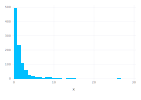

In [16]:
nbin = Int64(floor(sqrt(n)))

plot(x=y, Geom.histogram(bincount=nbin))

### (c) Générez un échantillon de la loi *a posteriori* des paramètres en utilisant l'échantillonnage de Gibbs

Utilisez la loi *a priori* impropre suivante pour les paramètres :
$$f_{\boldsymbol{\theta}}(\boldsymbol{\theta}) \propto (1-\omega)^{-1}\omega^{-1} \times \lambda_0^{-1} \times \lambda_1^{-1}.$$

Faîtes au moins 1000 itérations pour l'échantillonnage de Gibbs. Tracez les chaînes marginales générées.

In [17]:
niter = 1000
ω = zeros(niter)
λ₀ = zeros(niter)
λ₁ = zeros(niter)

ω[1] = .5
λ₀[1] = 1
λ₁[1] = 1

z = falses(n,niter)

for i=2:niter
   
    p = ω[i-1]*λ₁[i-1]*exp.(-λ₁[i-1]*y) ./ ( (1-ω[i-1])*λ₀[i-1]*exp.(-λ₀[i-1]*y) + ω[i-1]*λ₁[i-1]*exp.(-λ₁[i-1]*y) )
    
    u = rand(n)
    
    z[:,i] = u .< p
    
    n₁ = count(z[:,i])
    n₀ = n - n₁
    
    y₀ = y[.!(z[:,i])]
    y₁ = y[z[:,i]]
    
    ω[i] = rand(Beta(n₁, n₀))
    
    λ₀[i] = rand(Gamma(n₀, 1/sum(y₀)))
    
    λ₁[i] = rand(Gamma(n₁, 1/sum(y₁)))
    
end

df = DataFrame(Itération = 1:niter, ω = ω, λ₀ = λ₀, λ₁ = λ₁)
first(df,5)

,Itération,ω,λ₀,λ₁
,Int64,Float64,Float64,Float64
1,1,0.5,1.0,1.0
2,2,0.489296,0.603947,0.594292
3,3,0.479546,0.677199,0.609298
4,4,0.504612,0.684519,0.577897
5,5,0.505511,0.723129,0.52135


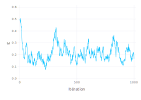

In [18]:
plot(df, x=:Itération, y=:ω, Geom.line)

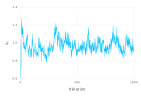

In [19]:
plot(df, x=:Itération, y=:λ₀, Geom.line)

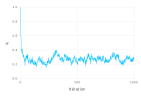

In [20]:
plot(df, x=:Itération, y=:λ₁, Geom.line)

### (d) Estimez les paramètres avec l'algorithme EM

Vous devez trouvez les expressions des estimations améliorées pour le mélange de lois exponentielles avec l'algorithme EM.

In [31]:
niter = 100
ω = zeros(niter)
λ₀ = zeros(niter)
λ₁ = zeros(niter)

ω[1] = .1
λ₀[1] = 1
λ₁[1] = 1/10

for i=2:niter
   
    p = ω[i-1]*λ₁[i-1]*exp.(-λ₁[i-1]*y) ./ ( (1-ω[i-1])*λ₀[i-1]*exp.(-λ₀[i-1]*y) + ω[i-1]*λ₁[i-1]*exp.(-λ₁[i-1]*y) )
    
    ω[i] = sum(p)/n
    
    λ₀[i] = sum(1 .- p) / sum( (1 .- p) .* y )
    
    λ₁[i] = sum(p) / sum(p .* y)
    
end

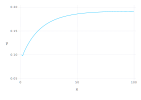

In [32]:
plot(x=1:niter, y=ω, Geom.line)

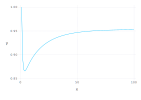

In [35]:
plot(x=1:niter, y=λ₀, Geom.line)

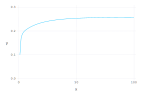

In [34]:
plot(x=1:niter, y=λ₁, Geom.line)